In [1]:
# jupyter auto reload
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
#io
import ND2Loader

# segmentation
import torch_seg
import keras_seg
from MicroscopyPreprocessor import MicroscopyPreprocessor

# utils
import numpy as np

# visualization
from segutils import Visualizer as vis

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


# Read Data

In [3]:
images = ND2Loader.read_dir('resources',
                            images_only=True,
                            ph3={'ph3'},
                            fluo={'mCherry', 'YFP'},
                            ph3_mask={'Threshold (ph3)'},
                            fluo_mask={'threshold (yfp)', 'threshold (mcherry)'})

ph3 = images['ph3']
fluo = images['fluo']
ph3_mask = images['ph3_mask']
fluo_mask = images['fluo_mask']

/Users/guyazran/Desktop/School/Bachelor/Computer Science/Year 4/Semester A/Research Project/venv-bio/lib/python3.6/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")


# Cell Segmentation

In [4]:
cell_probs, cell_boxes = torch_seg.full_segmentation(
    ph3,
    'resources/models/weights/cells_mask_rcnn_torch.pkl',
    threshold=0.95
)

/Users/guyazran/Desktop/School/Bachelor/Computer Science/Year 4/Semester A/Research Project/venv-bio/lib/python3.6/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [5]:
cell_probs.shape

(2, 1022, 1024)

In [6]:
working_cells_idx = 0
cell_seg_img = ph3[working_cells_idx]
cell_true_mask = ph3_mask[working_cells_idx]
cell_pred_boxes = cell_boxes[working_cells_idx]
cell_pred_probs = cell_probs[working_cells_idx]

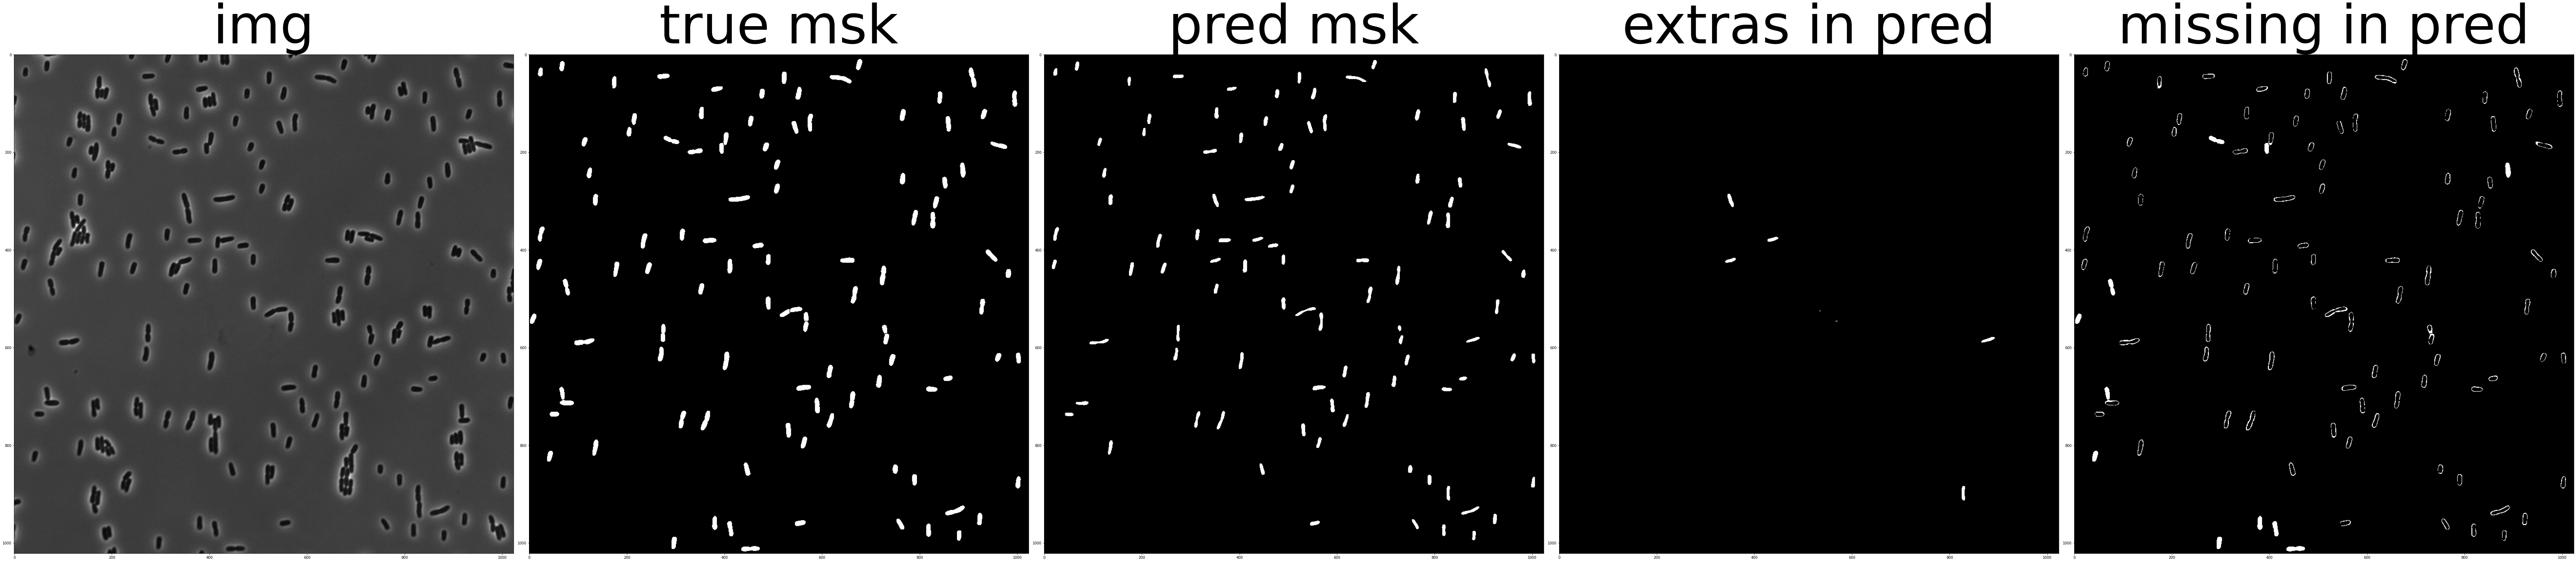

In [7]:
keras_seg.vis.compare_images(cell_seg_img, cell_true_mask, cell_pred_probs, 0.95)

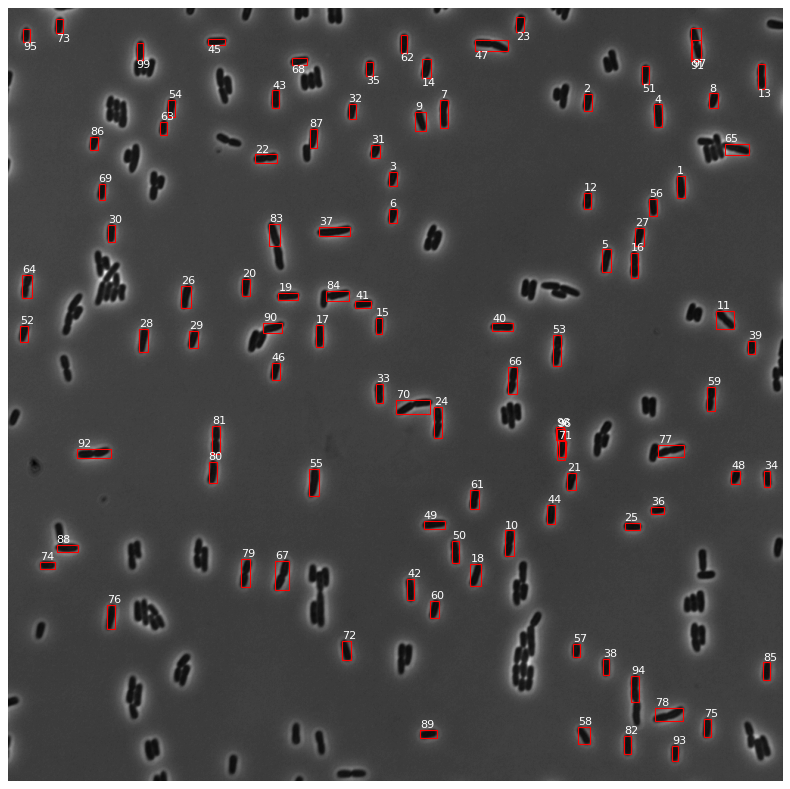

In [8]:
vis(cell_seg_img).add_bbox_stack(cell_pred_boxes).show();

# Protein Cluster Segmentation

In [9]:
fluo_cell_mixed_img = images = np.stack([ph3, fluo, fluo], axis=-1)
fluo_cell_mixed_img.shape

(2, 1022, 1024, 3)

In [10]:
fluo_masks, fluo_boxes, fluo_probs = keras_seg.full_segmentation(
    fluo_cell_mixed_img,
    'resources/models/config/fluo_fpn.yaml',
    'resources/models/weights/fluo_fpn_keras.hd5',
    preprocessor=MicroscopyPreprocessor,
    threshold=0.1,
    with_probs=True
)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
working_fluo_idx = 0
fluo_seg_img = fluo[working_fluo_idx]
fluo_true_mask = fluo_mask[working_fluo_idx]
fluo_pred_boxes = fluo_boxes[working_fluo_idx]
fluo_pred_probs = fluo_probs[working_fluo_idx]

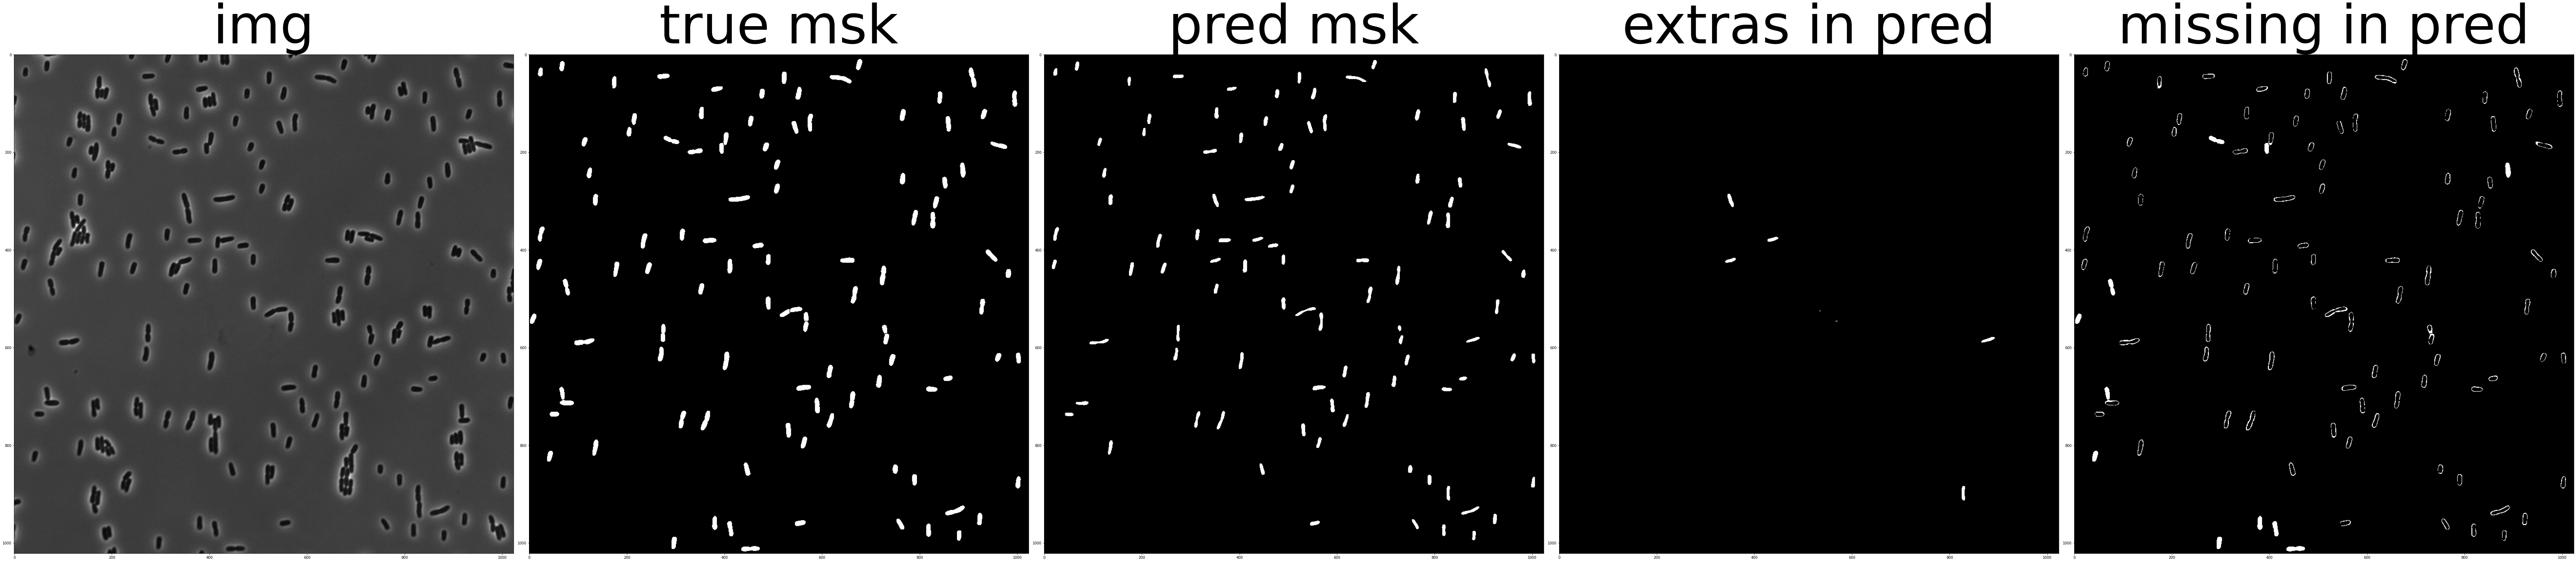

In [12]:
keras_seg.vis.compare_images(cell_seg_img, cell_true_mask, cell_pred_probs, 0.9)

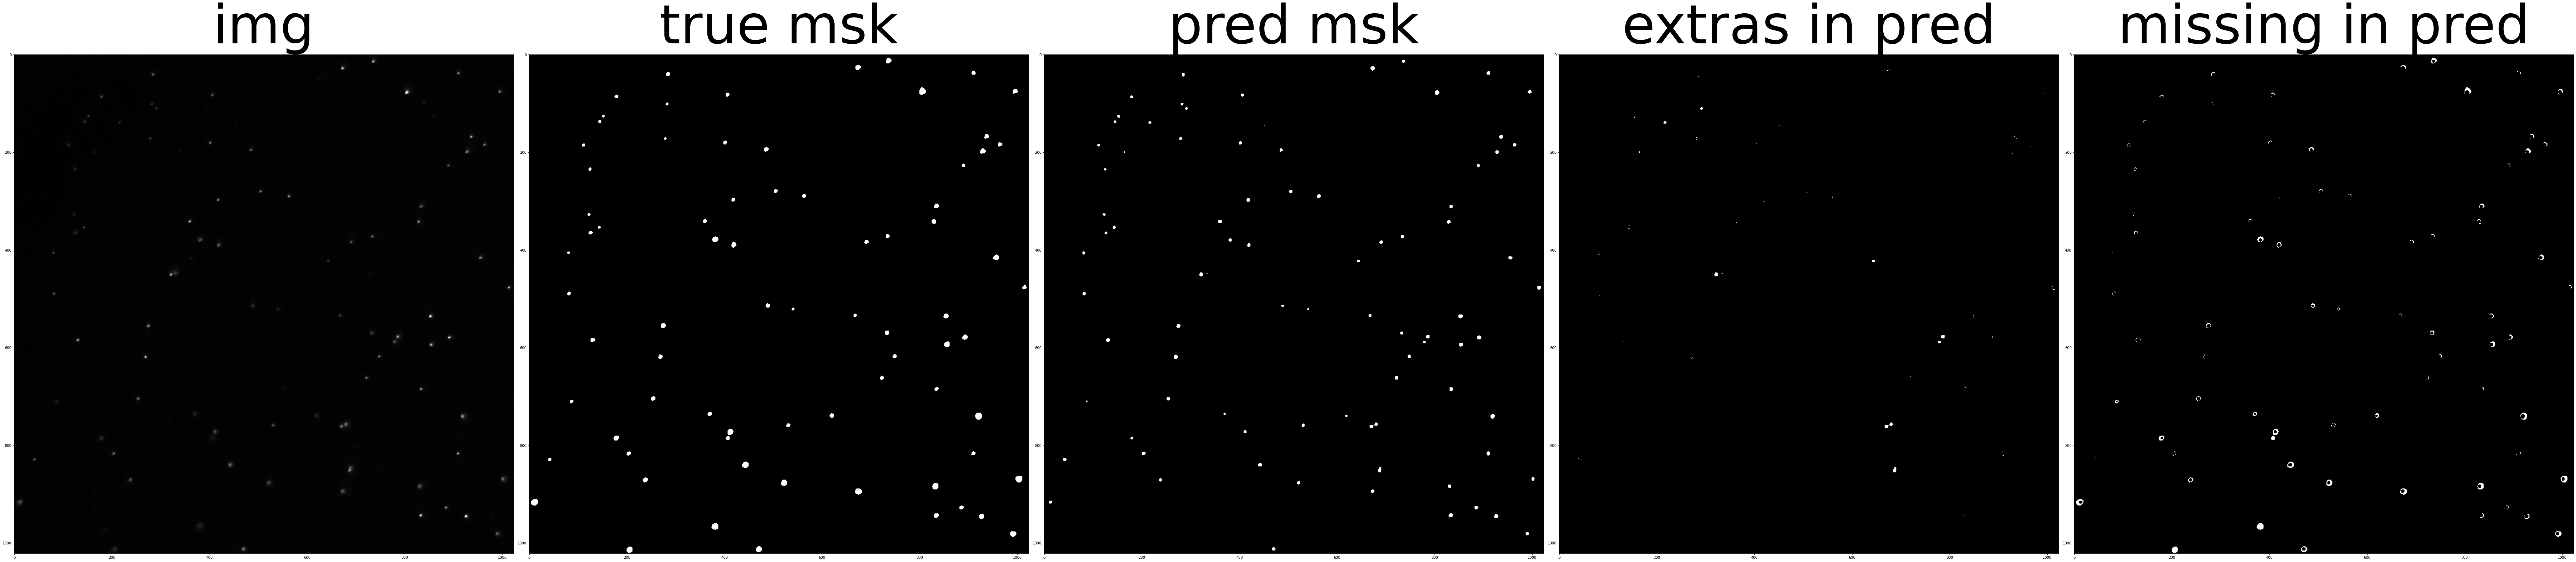

In [13]:
keras_seg.vis.compare_images(fluo_seg_img, fluo_true_mask, fluo_pred_probs, 0.1)

In [14]:
true_boxes = keras_seg.postprocessing.get_bboxes(keras_seg.postprocessing.label_mask_stack(fluo_true_mask[None])[0])

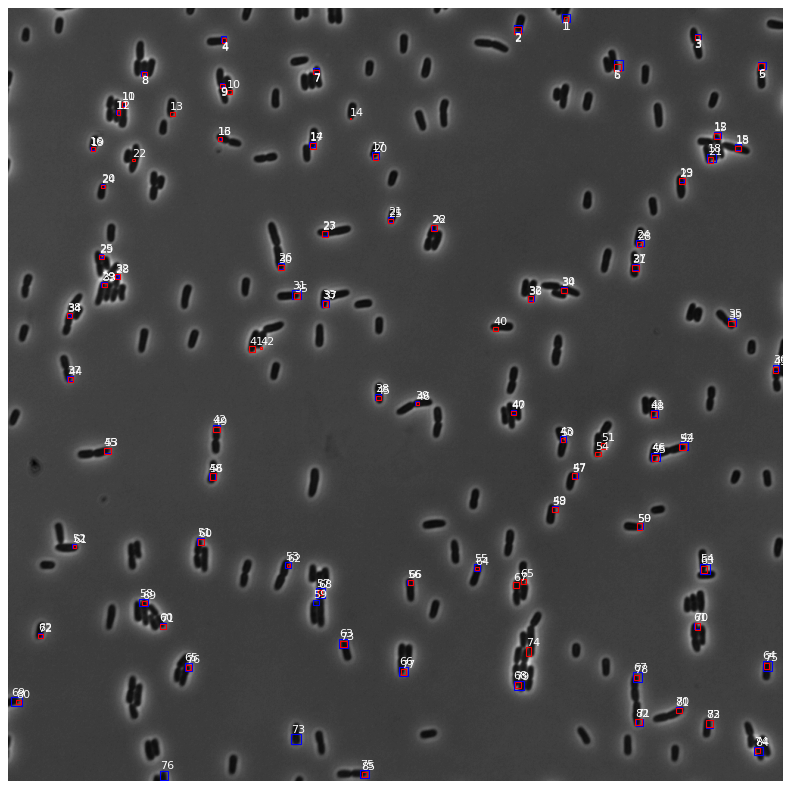

In [15]:
vis(cell_seg_img).add_bbox_stack(true_boxes, padding=0, color='blue').add_bbox_stack(fluo_pred_boxes, range(len(true_boxes), len(true_boxes)+len(fluo_pred_boxes))).show()